<a href="https://colab.research.google.com/github/VitaT/ML-python/blob/main/11_26_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suicide dataset

Target value y is number of suicides (suicides_no) or normalized suicide count by countries population size (suicides per 100 k people)

Everything else can be used as predictors.

In [4]:
import matplotlib.pyplot as plt   # visualization
import seaborn as sns             # visualization
import numpy as np                # data manipulation
import pandas as pd               # data manipulation, data processing, CSV file I/O (e.g. pd.read_csv
from sklearn import pipeline
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, train_test_split


plt.rcParams['figure.figsize'] = [14, 10]   # to have bigger plots


url = "https://raw.githubusercontent.com/VitaT/ML-python/main/data/suicides.csv"
data = pd.read_csv(url)

## Clean up

In [5]:
# Checking data
data.info()
data.head(5)
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  27820 non-null  int64  
 1   sex                 27820 non-null  object 
 2   age                 27820 non-null  object 
 3   suicides_no         27820 non-null  int64  
 4   population          27820 non-null  int64  
 5   suicides/100k pop   27808 non-null  float64
 6   country-year        27820 non-null  object 
 7   HDI for year        8364 non-null   float64
 8   gdp_for_year ($)    27820 non-null  int64  
 9   gdp_per_capita ($)  27820 non-null  int64  
 10  generation          27820 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 2.3+ MB


,ID,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
16461,16462,male,15-24 years,11,98207,11.20,Mauritius2008,NaN,9990370016,8716,Millenials
23254,23255,male,35-54 years,122,314098,38.84,Slovenia2013,0.878,48116256926,24697,Generation X
12404,12405,male,35-54 years,165,675986,24.41,Ireland2014,0.916,258099014042,59634,Generation X
4464,4465,male,15-24 years,1270,17794434,7.14,Brazil2009,NaN,1667019780934,9283,Millenials
21511,21512,male,5-14 years,0,16998,0.00,Saint Lucia2003,NaN,823837141,5599,Millenials
19404,19405,male,75+ years,95,188250,50.46,Portugal1989,NaN,60600056659,6436,G.I. Generation
22470,22471,male,5-14 years,2,209400,0.96,Singapore1990,0.718,36152027893,14393,Generation X
10653,10654,female,75+ years,0,2204,0.00,Grenada2012,0.740,799882148,8382,Silent
23241,23242,male,55-74 years,118,227915,51.77,Slovenia2012,0.878,46352802766,23820,Boomers
16157,16158,female,75+ years,0,18314,0.00,Malta2013,0.837,10145114180,25191,Silent


In [6]:
# cleaning up
# spliting country-year column
data['year'] = data["country-year"].str[-4:]
data['country'] = data["country-year"].str.split("\d+", expand = True)[0]
# removing ID and country-year columns
data.drop(["ID", "country-year"], axis=1, inplace=True)

# renaming columns for more convenient use
data.rename(columns={'gdp_for_year ($)':'gdp_year', 'gdp_per_capita ($)':'gdp_capita', 'suicides/100k pop':'suicide_norm', "HDI for year":"hdi_year"}, inplace=True)
# data.columns = ["sex", "age", "suicides_no", "population", "suicide_norm", "hdi_year", "gdp_year", "gdp_capita", "generation", "year", "country"]

In [7]:
# are there any missing values?
data.isnull().values.any()

# which columns have missing data
data.isnull().sum()
data.columns[data.isnull().values.any(axis = 0)]

# which rows do have missing values in suicide?
id = data["suicide_norm"].isnull().values
data[id]
data[id].shape

# suicide per 100k people can be calculated from suicides_no and population. Let's check it they are the same
compare = data["suicide_norm"] == round(data["suicides_no"] / data["population"] * 100000,  2)
compare.value_counts()
data[np.invert(compare)]
round(data["suicides_no"] / data["population"] * 100000,  2)[np.invert(compare)]
# We can overwrite suicide_norm
data["suicide_norm"] = round(data["suicides_no"] / data["population"] * 100000,  2)

# what about hdi_year column?
id = data["hdi_year"].isnull().values
np.bincount(id) / len(id)
# 70 percent of hdi values are missing


array([0.30064702, 0.69935298])

## Exploration

In [8]:
data.info()
data.describe(include = ["float", "int"])
data.describe(include = ["object"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           27820 non-null  object 
 1   age           27820 non-null  object 
 2   suicides_no   27820 non-null  int64  
 3   population    27820 non-null  int64  
 4   suicide_norm  27820 non-null  float64
 5   hdi_year      8364 non-null   float64
 6   gdp_year      27820 non-null  int64  
 7   gdp_capita    27820 non-null  int64  
 8   generation    27820 non-null  object 
 9   year          27820 non-null  object 
 10  country       27820 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.3+ MB


,sex,age,generation,year,country
count,27820,27820,27820,27820,27820
unique,2,6,6,32,101
top,male,15-24 years,Generation X,2009,Netherlands
freq,13910,4642,6408,1068,382


Generation X
['1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016']
Silent
['1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016']
G.I. Generation
['1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000']
Boomers
['1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2011' '2012' '2013' '2014' '2015'
 '2016']
Millenials
['1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' 

101

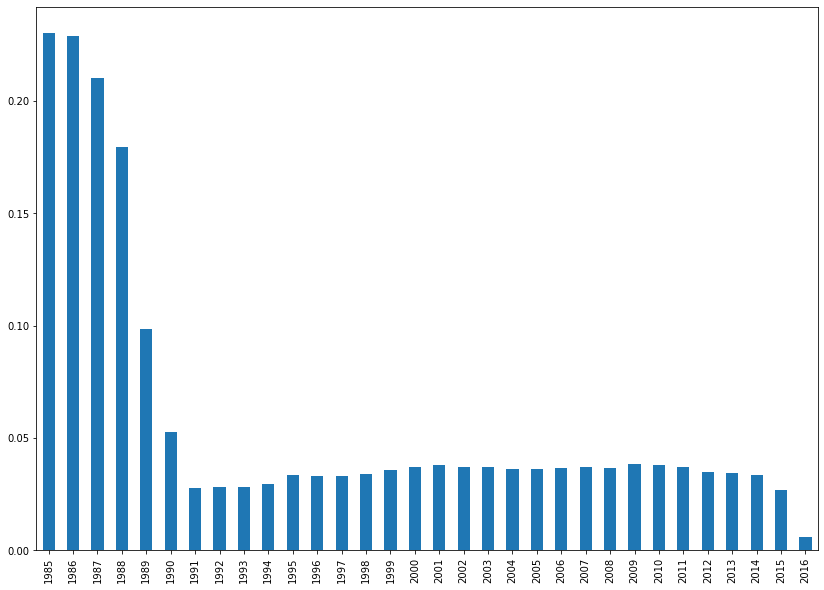

In [ ]:
# categorical values
# sex -- same number, full data for both sex
data["sex"].value_counts()

# age -- almost the same number for all categories. Age 5-14 from some countries is not present.
data["age"].value_counts() 

# generation
data["generation"].value_counts()
sp = data["generation"].value_counts() / data.shape[0]
sp.plot(kind = "bar")

# checking what years fall to different generations
for i in data.generation.unique():
  print(i)
  tmp = data.loc[data.generation == i].year.unique()
  print(np.sort(tmp))


# year -- 32 year data, from 1985 to 2016
data["year"].value_counts()
sp = data["year"].value_counts().sort_index() / data.shape[0]
sp.plot(kind = "bar")

# country -- 101 country data. 
data['country'].unique()
data['country'].nunique()

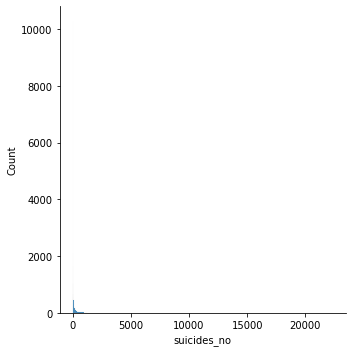

In [ ]:
# Q1. what does suicide distribution looks like?
sns.displot(data, x="suicides_no")
# raw suicide number distribution has very videly distributed values. Not very good for understanding data

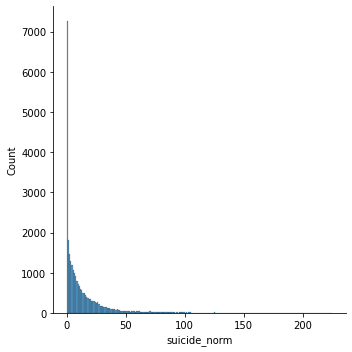

In [ ]:
sns.displot(data, x="suicide_norm")
# normalized by population size looks better -- have some very large normalized suicide values, but mostly suicide percentage follows an exponential distribution

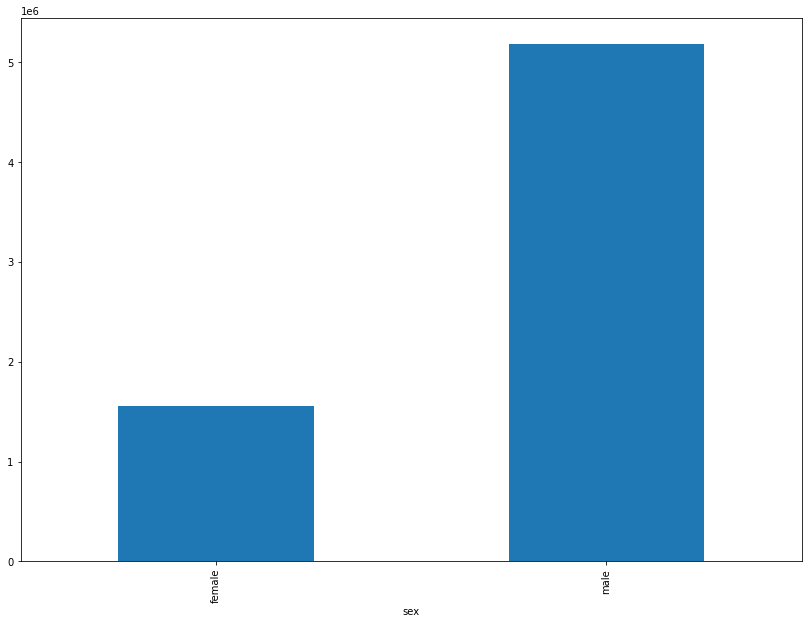

In [ ]:
# Q2. What are the number of suicides according to the sex?
sp = data.groupby('sex')['suicides_no'].sum()
sp.plot(kind='bar')
# more commonly suicide is commited by a male

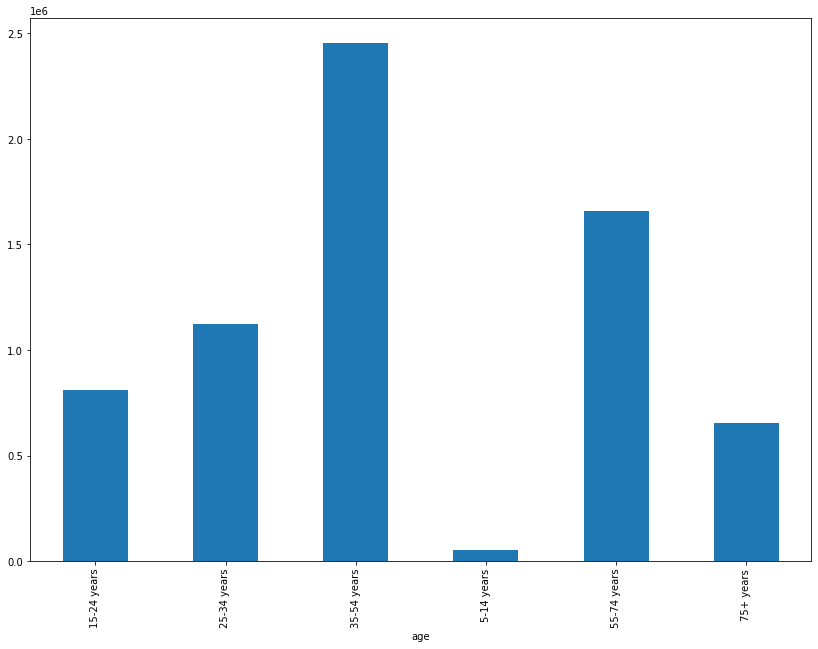

In [ ]:
# Q3. what are the number of suicides according to the age group?
sp = data.groupby('age')['suicides_no'].agg('sum')
sp.plot(kind='bar')
# most suicides are commited in the age interval 35-54

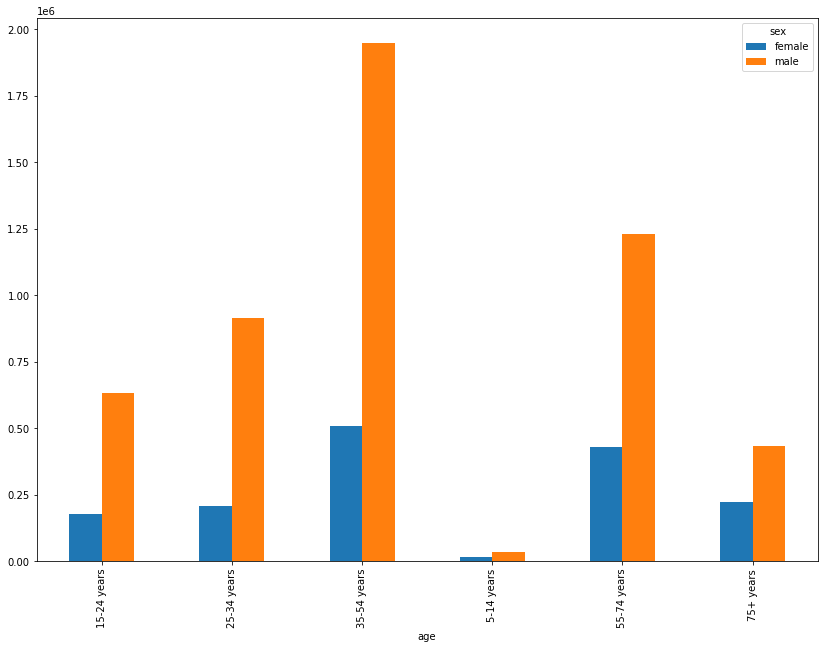

In [ ]:
# what about both, age interval and gender influence on suicide number?
sp = data.groupby(['age', 'sex'])['suicides_no'].agg('sum').unstack('sex')
sp.plot.bar()
# in all age categories there are more male suicides

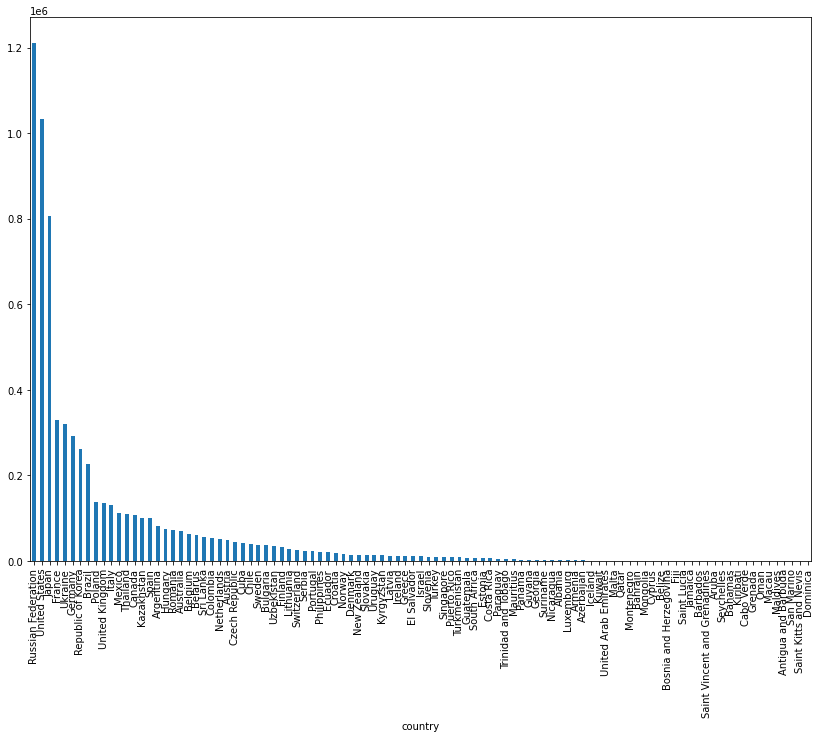

In [ ]:
# Q4. What is total and relatice suicide count by the country?
# total suicide number
sp = data.groupby('country')['suicides_no'].agg('sum').sort_values(ascending=False)
sp.plot(kind = "bar")


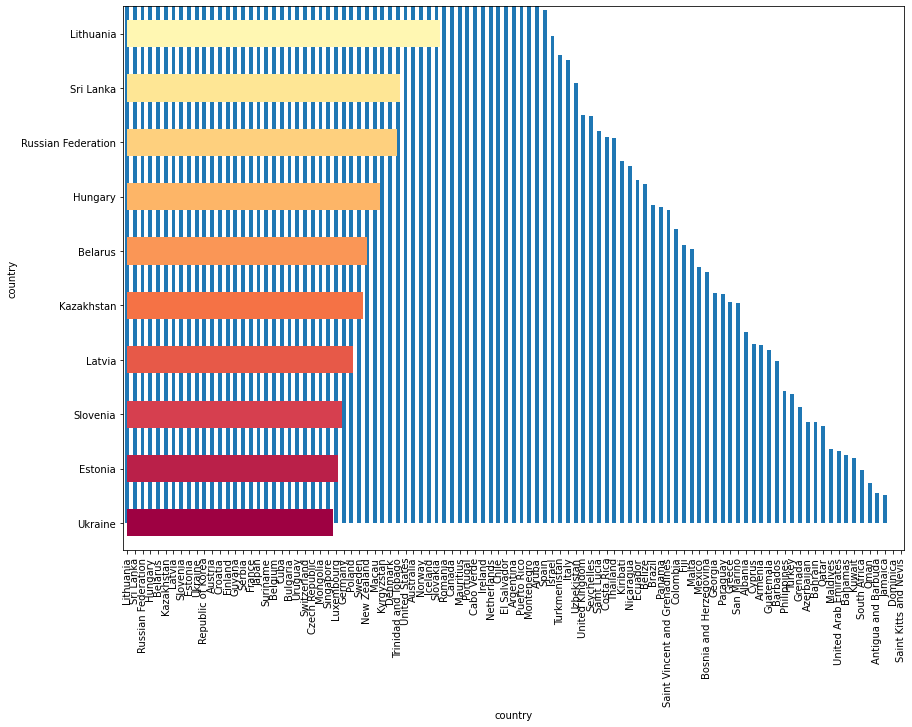

In [ ]:
# over all the years normalized by population sum of suicides
sp = data.groupby('country')['suicide_norm'].agg('mean').sort_values(ascending=False)
sp.plot(kind='bar')


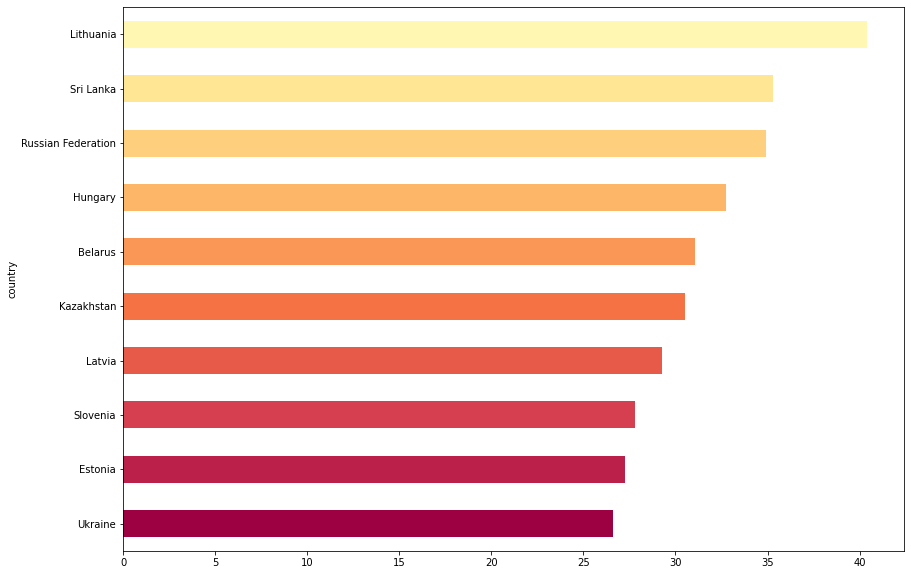

In [ ]:
# top 10 countries
col = plt.cm.Spectral(np.linspace(0, 1, 20))
sp.nlargest(10).sort_values().plot(kind='barh', color = col)
top10 = sp.nlargest(10)

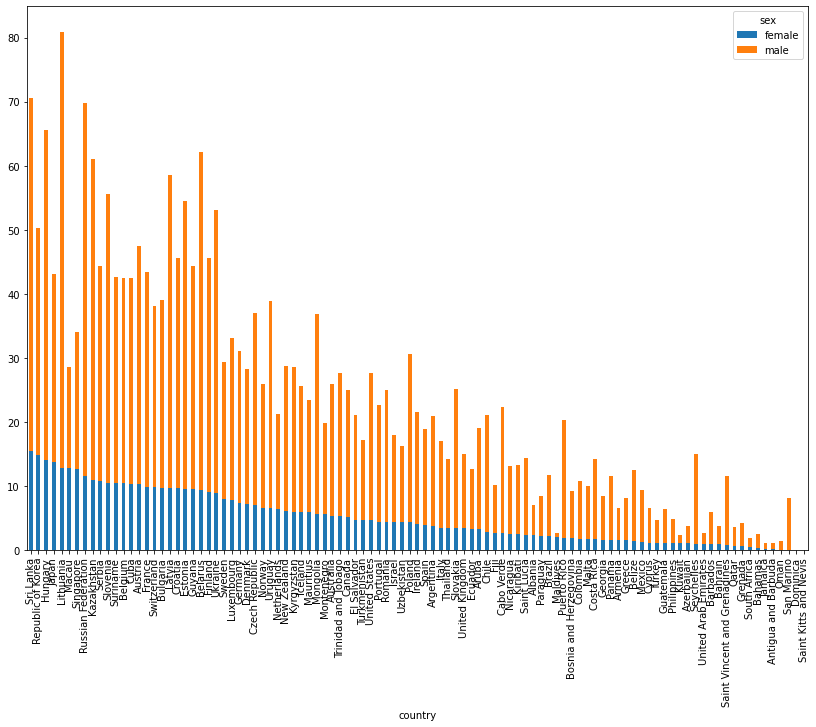

In [ ]:
# over all the years normalized by population sum of suicides
sp = data.groupby(['country', 'sex'])['suicide_norm'].agg("mean").unstack('sex').sort_values("female", ascending=False)
sp.plot(kind='bar', stacked = True)

In [ ]:
# Q5. What is total number of suicides in the world by year?
data.groupby("year")["suicides_no"].sum().plot()

In [ ]:
data.groupby("year")["suicides_no"].sum().plot(kind = "bar")
# year 2016 data seems to be unfinished. Maybe the data was collected at the start of 2016

In [ ]:
# Which year has the most total Suicides? the least?
tmp = data.groupby("year")["suicides_no"].sum().reset_index().sort_values("suicides_no")
tmp.head()
tmp.tail()
# most 1999, least -- 2016 and 1985

# what if we plot average suicide count off all human population size
sp = data.groupby(["year"])["suicides_no", "population"].sum().reset_index("year")
sp["suicide_pop"] = sp["suicides_no"] / sp["population"]
sp.plot(x = "year", y = "suicide_pop")

In [ ]:
## Suicides number per 100k population by year and country
sp = data.groupby(['country', 'year'])[['suicide_norm']].mean().reset_index()
sp.sort_values("suicide_norm", ascending=False).head(20)


In [ ]:
# what about relationship between gdp and suicide number normalized by population in a country (without separating age and sex groups)
sp = data.groupby(["country", "year", "gdp_year", "gdp_capita"])["population", "suicides_no"].sum().reset_index()
sp["suicide_norm"] = sp["suicides_no"] / sp["population"]
sp.plot.scatter("suicide_norm", "gdp_capita")

sns.scatterplot(data=sp, x = "suicide_norm", y = "gdp_year", hue = "year")
sns.scatterplot(data=sp, x = "suicide_norm", y = "gdp_capita", hue = "year")
sns.pairplot(sp)

In [ ]:
# ## Correlation of features
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

Text(0.5, 0, 'number of principal components')

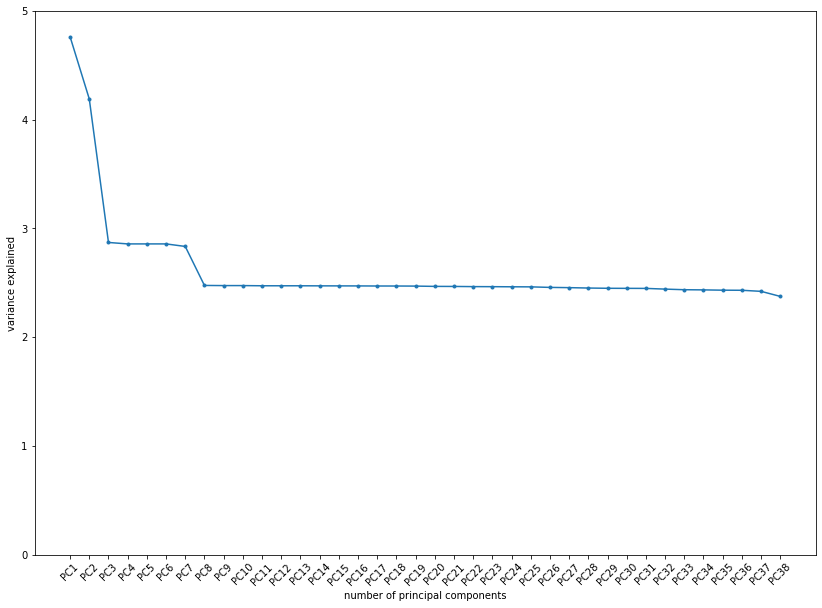

In [11]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# create PCA estimator
pca = PCA(n_components=0.99)

# clean data
x = data.drop(["gdp_capita", "generation", "country", "hdi_year", "suicides_no", "suicide_norm"], axis = 1)
x = pd.get_dummies(x, columns=["sex", "age", "year"])
scaled_x = StandardScaler().fit_transform(x)

# pca
features_pca = pca.fit_transform(scaled_x)
# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_ * 100)
labels = ["PC" + str(x) for x in range(1, len(pca_var_ex)+1)]

plt.plot(labels, pca_var_ex, marker = ".")
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.ylabel("variance explained")
plt.xlabel("number of principal components")

Text(0.5, 0, 'pca_components')

<Figure size 1440x1080 with 0 Axes>

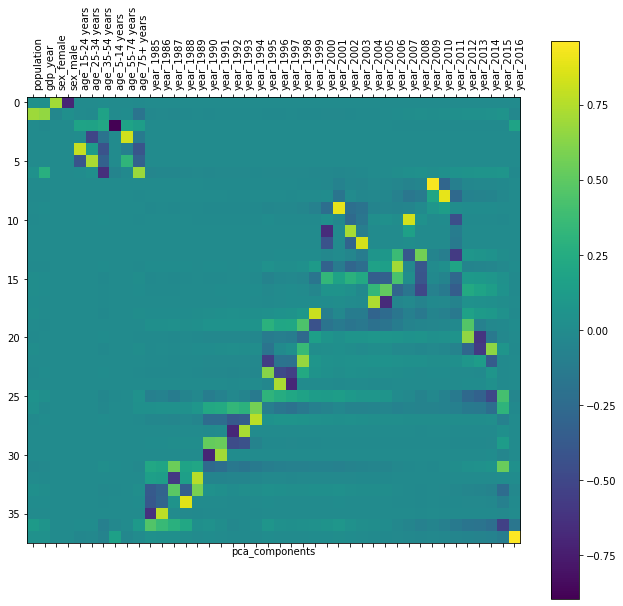

In [12]:
# PC composition
nfeat = x.shape[1]
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
plt.colorbar()
plt.xticks(range(nfeat), x.columns, rotation=90, ha='left')
plt.xlabel("pca_components")

## Prediction -- Regression

So, what variables should we include?

Should we model suicide number of normalized suicide count by population size?

In [13]:
y = np.array(data["suicides_no"])
x = data.drop(["suicides_no", "suicide_norm"], axis = 1)

# we have to many countries, so let's drop country column. 
# generation is also not informative.
# dpg per capita is made from gdp per year and population, so will not use it
# hdi -- has a lot of NAN
x = x.drop(["gdp_capita", "generation", "country", "hdi_year"], axis = 1)
x = pd.get_dummies(x, columns=["sex", "age", "year"])
column_names = x.columns

from sklearn.preprocessing import StandardScaler
scaled_x = StandardScaler().fit_transform(x)
scaled_y = StandardScaler().fit_transform(y.reshape(-1, 1))

In [14]:
# testing and training sets.
x_pca, x_pca_out, y, y_out = train_test_split(features_pca, scaled_y, test_size = 0.2, random_state = 0)
x, x_out, y, y_out = train_test_split(scaled_x, scaled_y, test_size = 0.2, random_state = 0)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train MSE 0.6298191438754773
test MSE 0.3800685242792668


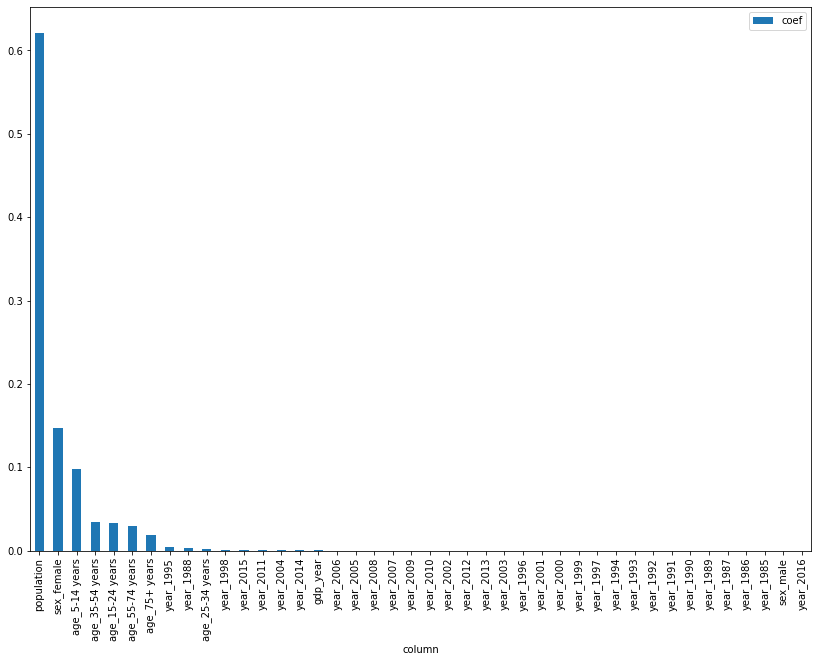

In [41]:
# lasso 
lasso_cv = LassoCV(cv=KFold(5, True, 0)).fit(x, y)

# regularization parameter
lasso_alpha = lasso_cv.alpha_

# what features were selected?
id = lasso_cv.coef_ != 0
column_names[id]
lasso_cv.coef_[id]
n_features = len(lasso_cv.coef_[id])
# order them by importance
importance = pd.DataFrame({"coef" : np.abs(lasso_cv.coef_), "column": column_names})
importance = importance.sort_values("coef", ascending=False)
importance.plot(kind = "bar", x = "column", y = "coef")

# test and train values with selected alpha
lasso = Lasso(alpha = lasso_alpha)
lasso.fit(x, y)
print("train MSE", mean_squared_error(lasso.predict(x), y))
print("test MSE", mean_squared_error(lasso.predict(x_out), y_out))


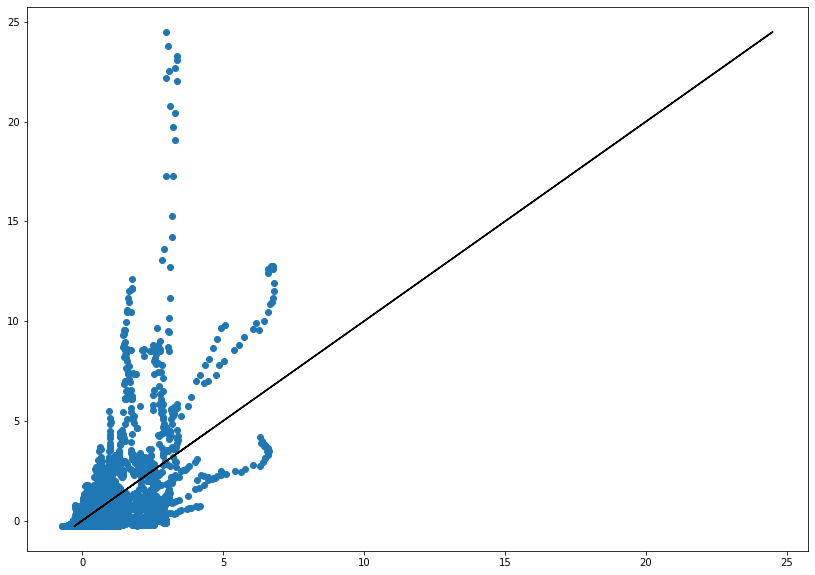

In [40]:
# residuals
y_pred_train = lasso.predict(x)
plt.scatter(y_pred_train, y)
plt.plot(y, y,'k-') # identity line


In [ ]:
# KNN model
# Create a KNN classifie()
knn = KNeighborsRegressor(n_neighbors=5)
# Create a pipeline
pipe = pipeline.Pipeline([("knn", knn)])
# Create space of candidate values
search_space = [{"knn__n_neighbors": [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]

# use GridSearchCV to conduct ten-fold cross-validation on KNN classifiers with different values of k
classifier = GridSearchCV(pipe, search_space, cv=KFold(5, True, 0), scoring="neg_mean_squared_error", return_train_score=True).fit(x, y)

classifier.best_estimator_
classifier.best_estimator_.get_params()["knn__n_neighbors"]

classifier.cv_results_
pd.DataFrame(classifier.cv_results_)

# Calculating error for K values between 1 and 12
# for i in k_range:
#     knn = KNeighborsRegressor(n_neighbors=i)
#     scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
#     all_scores.append(scores)
#     mean_scores.append(np.mean(scores))

# plt.figure(figsize=(12, 6))
# plt.plot(k_range, all_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='blue')
# plt.plot(k_range, mean_scores, color='red', linestyle='dashed', marker='o', markerfacecolor='red')
# plt.xlabel('K Value')
# plt.ylabel('score')

## Prediction -- classification

exercise for you -- let's say

* Suicides per 100k < mean(Suicides per 100k) --> low risk --> class 0
* Suicides per 100k > mean(Suicides per 100k) --> high risk --> class 1

create a model to evaluate if a country is high suicide risk or not